<a href="https://colab.research.google.com/github/chris-kehl/spiderClassifierXresnet50/blob/main/Spider_Classifier_Xresnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import all the needed libraries and packages
!pip install -Uqq fastbook
import fastbook
import warnings
import os 
fastbook.setup_book()
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import cnn_learner

     |████████████████████████████████| 720 kB 7.0 MB/s 
     |████████████████████████████████| 1.2 MB 37.5 MB/s 
     |████████████████████████████████| 189 kB 37.9 MB/s 
     |████████████████████████████████| 46 kB 4.1 MB/s 
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 51 kB 323 kB/s 
Mounted at /content/gdrive


In [2]:
# enable fastai to access the GPU
# ensure to enable runtime to GPU 
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

!nvidia-smi

Tue Nov  9 09:32:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# look at current directory
os.getcwd()

'/content'

In [4]:
# change to your working directory where you have your spider folders
os.chdir('/content/gdrive/MyDrive/')
os.getcwd()

'/content/gdrive/MyDrive'

In [5]:
path = Path('spider')

In [6]:
fns = get_image_files(path)
fns

(#4744) [Path('spider/brown-recluse.jpeg'),Path('spider/Southern Black Widow/00000003.jpg'),Path('spider/Southern Black Widow/00000006.jpg'),Path('spider/Southern Black Widow/00000005.jpg'),Path('spider/Southern Black Widow/00000009.jpg'),Path('spider/Southern Black Widow/00000001.jpg'),Path('spider/Southern Black Widow/00000012.jpg'),Path('spider/Southern Black Widow/00000004.jpg'),Path('spider/Southern Black Widow/00000000.jpg'),Path('spider/Southern Black Widow/00000007.jpg')...]

In [7]:
class DataLoaders(GetAttr):
  def __init(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train, valid = add_props(lambda i,self: self[i])


In [8]:
# were using the splitter here to split the data 80% training set and 20% test set
# with this we are resizing our images to 224
spiders = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224))

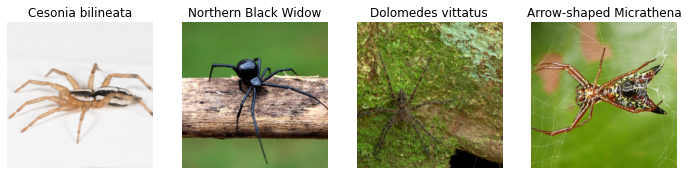

In [9]:
batch_tfms=aug_transforms(size=224, min_scale=0.75)
dls = spiders.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [10]:
model=xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.757425,17.687090,0.033755,07:25
1,3.600836,3.445258,0.100211,01:27
2,3.379047,3.480368,0.117089,01:27
3,3.146384,3.181969,0.158228,01:27
4,2.935927,3.144247,0.168776,01:26


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-pack

In [11]:
# Normalize the 0 to 255 to have a value between 0 and 1
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),

batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
            
Normalize.from_stats(*imagenet_stats)])
    
    return dblock.dataloaders(path, bs=bs) 

dls = get_dls(64, 500)

x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


(TensorImage([0.2966, 0.3515, 0.1806], device='cuda:0'),
 TensorImage([1.2265, 1.2259, 1.3088], device='cuda:0'))

In [12]:
# Train the normalized data
model = xresnet50()
learn = Learner(dls, model,loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.038514,7.530668,0.056962,01:35
1,3.749523,3.647445,0.056962,01:35
2,3.463883,3.761106,0.116034,01:37
3,3.233107,3.169113,0.154008,01:37
4,3.032306,3.110741,0.180380,01:35


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


SuggestedLRs(valley=0.00013182566908653826)

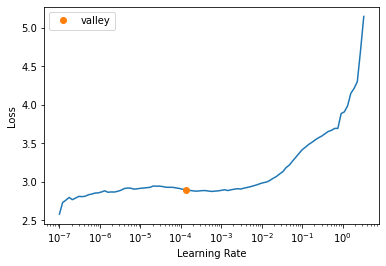

In [13]:
learn.unfreeze()
learn.lr_find()

In [14]:
# Using progressive resizing
dls = get_dls(64, 64)
learn = Learner(dls, xresnet50(n_out=dls.c),
                loss_func=CrossEntropyLossFlat(),
                metrics=accuracy)
learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.705286,3.490418,0.099156,01:31
1,3.448828,3.382145,0.120253,01:32
2,3.264029,3.328142,0.141350,01:31
3,3.147883,3.319267,0.145570,01:30


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes sh

In [15]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(n_out=dls.c),
                loss_func=CrossEntropyLossFlat(),
                metrics=accuracy)
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.812624,3.529245,0.093882,01:28
1,3.520963,3.312144,0.136076,01:29
2,3.338864,3.241070,0.151899,01:28
3,3.219776,3.224937,0.167722,01:29
4,3.140080,3.217865,0.165612,01:33


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

In [16]:
dls = get_dls(64, 224)
learn = Learner(dls, xresnet50(n_out=dls.c),
                loss_func=CrossEntropyLossFlat(),
                metrics=accuracy)
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.691993,3.410593,0.112869,01:34
1,3.415757,3.312765,0.131857,01:34
2,3.246012,3.222082,0.166667,01:34
3,3.140528,3.196593,0.158228,01:35
4,3.053372,3.192702,0.160338,01:37


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Im

In [17]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(),
                metrics=accuracy)
learn.fit_one_cycle(250, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.885806,3.814503,0.027426,01:36
1,3.785548,3.718345,0.047468,01:35
2,3.713315,3.645967,0.061181,01:37
3,3.639299,3.589798,0.080169,01:36
4,3.572977,3.545705,0.093882,01:36
5,3.525192,3.509173,0.114979,01:38
6,3.484064,3.479705,0.112869,01:37
7,3.455633,3.461410,0.110759,01:36
8,3.420006,3.436977,0.119198,01:35
9,3.384555,3.421123,0.128692,01:33


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


SuggestedLRs(valley=2.0892961401841603e-05)

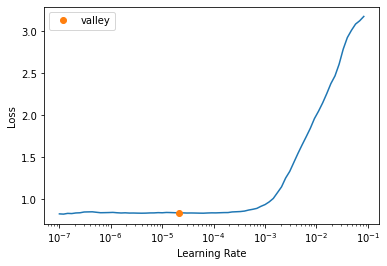

In [18]:
learn.lr_find()

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


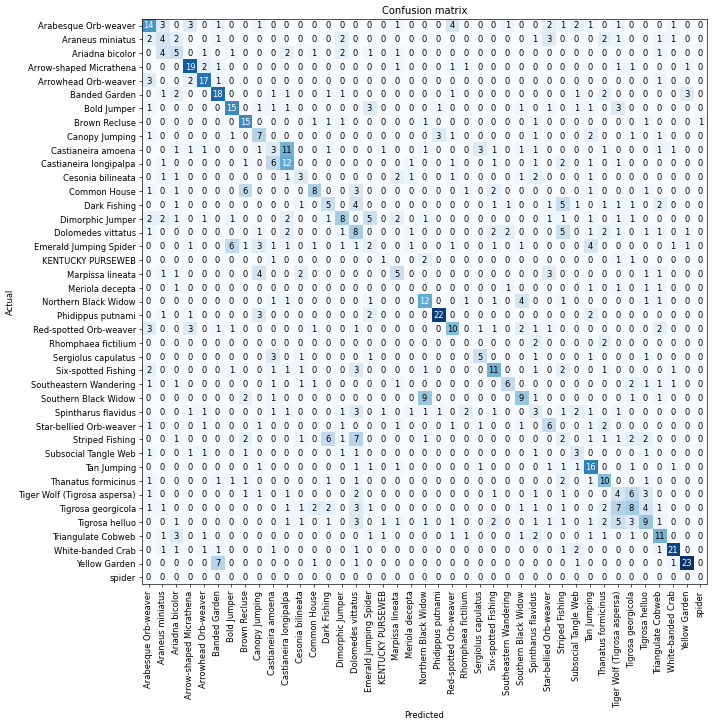

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [20]:
interp.most_confused(min_val=10)

[('Castianeira amoena', 'Castianeira longipalpa', 11)]

In [21]:
# export FastAI learner

learn.export('spider/spider_model.pkl')